# Analyst of user characteristic and social network in Sina Weibo Topics


In [15]:
#-*- coding:utf-8 -*-
%matplotlib inline
import json
import crawler
import time
import datetime
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.font_manager import FontProperties
import numpy as np
import random
import re
import pickle
import sys

In [376]:
'''Function for grabbing user infomation.'''
def get_basic_info(uid, cookie, retry):
    user_info_v2 = crawler.get_user_info_by_id_v2(uid, cookie, retry)
    if user_info_v2 == 0:
        return 0
    temp = user_info_v2.decode('utf8')
    location_re = re.compile(u'(所在地</span><p>)(.{1,20})(</p>)')
    location = location_re.search(temp)
    #print location.group(2)[0:2]
    if location:
        location = location.group(2)[0:2]
    else:
        location = '-1'

    e_r = u'(教育信息</h2><section class="list-info-page"><div class="item-info-page"><span>)'
    e_r += u"(.{1,20})(</span>)"
    education_re = re.compile(e_r)
    education = education_re.search(temp)
    #print education.group(2)
    if education:
        education = education.group(2)
    else:
        education = '-1'
        
    
    birth_re = re.compile(u'(生日</span><p>)(\d{4}-\d{2}-\d{2})(</p>)')
    birth = birth_re.search(temp)
    if birth:
        birth = birth.group(2)
        birth = datetime.datetime.strptime(birth, '%Y-%m-%d')
        #print birthday
        now = datetime.datetime.now()
        age = str((now - birth).days / 365)
    else:
        age = '-1'
    
    return (location, education, age)

'''Stats'''
def dict_stat(all_info):
    location_dict = {}
    education_dict = {}
    birth_dict = {'<12':0,
              '12-15':0,
              '15-18':0,
              '18-23':0,
              '23-28':0,
              '28-35':0,
              '35-45':0,
              '45-55':0,
              '>55':0
             }
    for info in all_info:
        if info[0] != '-1':
            if info[0] in location_dict:
                location_dict[info[0]] += 1
            else:
                location_dict[info[0]] = 1
    
        if info[1] != '-1':
            if info[1] in education_dict:
                education_dict[info[1]] += 1
            else:
                education_dict[info[1]] = 1
            
        if info[2] != '-1':
            if int(info[2]) <= 12:
                birth_dict['<12'] += 1
            elif int(info[2]) > 12 and int(info[2]) <= 15:
                birth_dict['12-15'] += 1
            elif int(info[2]) > 15 and int(info[2]) <= 18:
                birth_dict['15-18'] += 1
            elif int(info[2]) > 18 and int(info[2]) <= 23:
                birth_dict['18-23'] += 1
            elif int(info[2]) > 23 and int(info[2]) <= 28:
                birth_dict['23-28'] += 1
            elif int(info[2]) > 28 and int(info[2]) <= 35:
                birth_dict['28-35'] += 1
            elif int(info[2]) > 35 and int(info[2]) <= 45:
                birth_dict['35-45'] += 1
            elif int(info[2]) > 45 and int(info[2]) <= 55:
                birth_dict['45-55'] += 1
            elif int(info[2]) > 55:
                birth_dict['>55'] += 1
    return [location_dict, education_dict, birth_dict]

In [16]:
'''Cell for reload crawler in case modified'''
reload(crawler)

<module 'crawler' from 'crawler.pyc'>

In [ ]:
'''Get topic by keyword'''
theme_weibo = crawler.get_theme_by_keyword('杨绛',page=1)
for i in xrange(0, len(theme_weibo)):
    theme_weibo[i] = json.dumps(theme_weibo[i],skipkeys = True,ensure_ascii = False, encoding = 'gb2312', indent = 4)
    print theme_weibo[i]

In [ ]:
total = crawler.get_weibo_by_theme('23053010080819c366f62380fecd399270159fcc2184__timeline__mobile_info_-_pageapp%3A23055763d3d983819d66869c27ae8da86cb176', 
                                   '5223526177', cookie, page=1, retry = 5)
for i in xrange(0, len(total)):
    total[i] = json.dumps(total[i],skipkeys = True,ensure_ascii = False, encoding = 'gb2312', indent = 4)
    print total[i]

In [13]:
'''爬取话题讨论用户的基本信息（uid，昵称，性别）'''
interval = 1
iteration = 2
total = crawler.get_weibo_by_theme('23053010080819c366f62380fecd399270159fcc2184__timeline__mobile_info_-_pageapp%3A23055763d3d983819d66869c27ae8da86cb176', 
                                   '5223526177', cookie, page=1, retry = 5)
theme = 'UEFA Final'
print 'theme => ' + theme + ':'
theme_users = total[0]
print 'users in discussion:'
Max = 500 #上限500页，可保证5000个用户的数据量
Last = total[1] #下一页url中的last_since_id
Next = total[2] #下一页url中的next_since_id
users_list = []
flag = 0
while iteration < Max:
    time.sleep(1.5)
    #print iteration
    total = crawler.get_weibo_by_theme('23053010080819c366f62380fecd399270159fcc2184__timeline__mobile_info_-_pageapp%3A23055763d3d983819d66869c27ae8da86cb176', 
                                   '5223526177', cookie, page=iteration*interval, retry = 5,
                                       last_since_id = Last, next_since_id = Next)
    if total == 0: #若返回0，则继续尝试
        flag += 1
        continue
    if flag == 4: #最多尝试4次，否则则判定网页被微博重定向，需换账号登陆
        break
    for i in total[0]:
        if i[1] not in users_list:
            users_list.append(i[1])
            theme_users.append(i)
    Last = total[1]
    Next = total[2]
    if iteration % 50 == 0: #每隔50页输出
        print iteration, ', '.join(total[0][0])
        print len(users_list)
    if iteration % 100 == 0: #每隔100页保存变量
        output = open('theme_users.pk1','wb')
        pickle.dump(theme_users, output, -1)
    iteration += 1
output = open('theme_users.pk1','wb')
pickle.dump(theme_users, output, -1)

theme => UEFA Final:
users in discussion:
50 中文乙, 5733501671, m
436
100 张艺萱Sunny, 1941536460, f
881
150 西班牙足球资讯站, 5887992338, m
1320
200 CCEspeRansA, 2594510722, f
1754
250 郑腾尧, 5180326512, f
2176
300 Coomassie, 3562478211, f
2603
350 陶罐人, 2521054814, m
3042
400 lasia-cons美瞳派, 5041831179, f
3465
450 只是差一点, 1820822935, f
3900


In [355]:
file = open('theme_users.pk1','rb')
theme_users = pickle.load(file)
file.close()

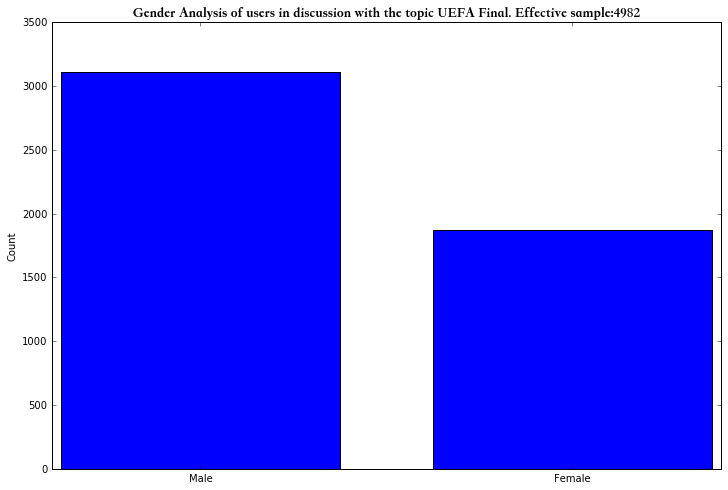

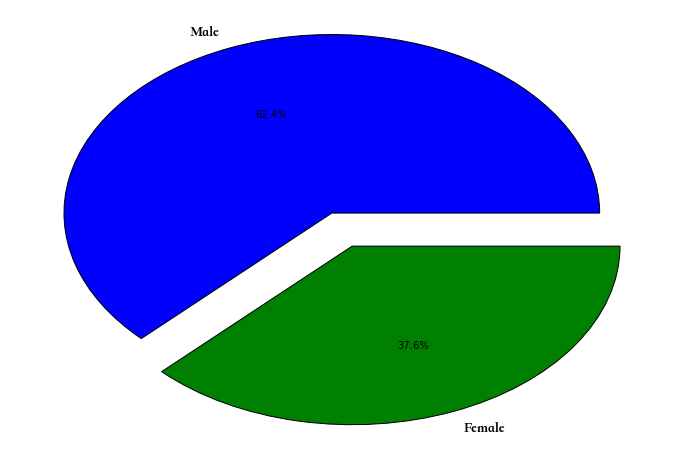

In [398]:
'''讨论用户的性别分析'''
m = 0
f = 0
theme = 'UEFA Final'
for i in theme_users:
    if i [2] == 'm':
        m += 1
    elif i[2] == 'f':
        f += 1
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
chfont = FontProperties(fname='/Library/Fonts/Kaiti.ttc', size=14)
index = np.arange(1, 3)
rect = plt.bar(left=index, height=(m,f), width = 0.75, align = 'center')
plt.title('Gender Analysis of users in discussion with the topic %s. Effective sample:%d' % (theme, len(theme_users)),
         fontproperties = chfont)
plt.ylabel('Count')
plt.xticks(index, ('Male','Female'))
plt.show()

pie = plt.pie((m, f), 
               labels = ('Male', 'Female'), 
               explode = np.ones(2)*0.1, 
               autopct = '%1.1f%%')
for font in pie[1]:
    font.set_fontproperties(chfont)
plt.show()

In [21]:
'''抓取讨论用户的所在地、教育信息和年龄信息'''
i = 0
theme_users_info = []
print 'Geting basic info...'
cookie ={'_T_WM':'a1f17feb717856dc5aab594c4aa54edb', 
              'gsid_CTandWM':'4ul2CpOz5sQwlt1Z0qgJEf4tl0L', 
              'H5_INDEX':'3', 'H5_INDEX_TITLE':'%E5%A4%A7%E9%BC%BB%E5%AD%90Rita%E8%BE%A3%E6%9D%A1%E5%90%9B', 
              'M_WEIBOCN_PARAMS':'featurecode%3D20000181%26fid%3D1005055223526177%26uicode%3D10000011',
              'SSOLoginState':'1464787807', 
              'SUB':'_2A256SpMPDeTxGeVL4lAQ8SvMzzuIHXVZtD1HrDV6PUJbkdBeLXn9kW16OgQoyYnQknIMK55WJU8UgAD5Ow..', 
              'SUHB':'0u5RcTRfvT5Y6q'}
while i < len(theme_users):
    #print ','.join(theme_users[i])
    time.sleep(3)
    info = get_basic_info(theme_users[i][1], cookie, 3)
    #if flag == 0:
        #i += 1
        #flag = 0
        #continue
    if info == 0:
        time.sleep(10)
        #flag += 1
        i+=1
        continue
    #print ','.join(info)
    theme_users_info.append(info)
            
    if (i+1)%500 == 0: #每隔500个进行输出
        print i
        print ','.join(info)
        output = open('theme_users_info.pk1','wb')
        pickle.dump(theme_users_info, output, -1)

    i += 1
    
output = open('theme_users_info.pk1','wb')
pickle.dump(theme_users_info, output, -1)


Geting basic info...
499
上海,-1,22
999
浙江,-1,-1
1499
其他,大学,-1
1999
广西,大学,18


KeyboardInterrupt: 

In [24]:
output = open('theme_users_info.pk1','wb')
pickle.dump(theme_users_info, output, -1)
output.close()

In [374]:
file = open('theme_users_info.pk1','rb')
theme_users_info = pickle.load(file)
file.close()

In [378]:
'''调用dict_stat函数对信息进行统计'''
location_dict, education_dict, birth_dict = dict_stat(theme_users_info)

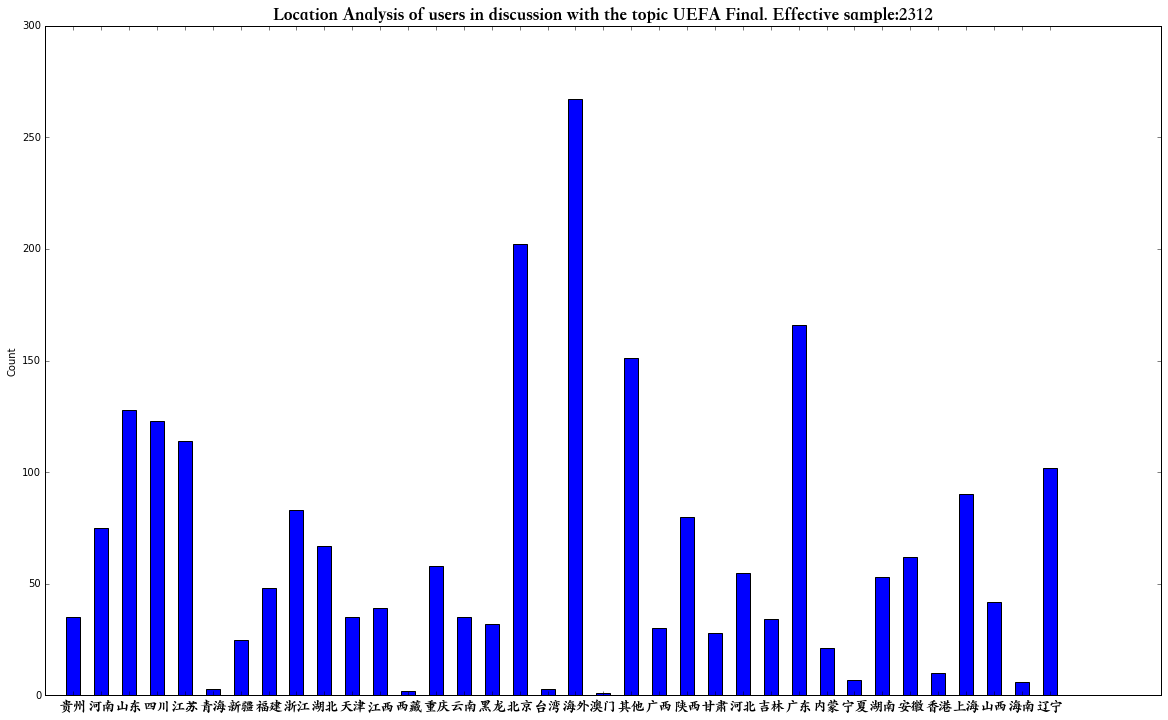

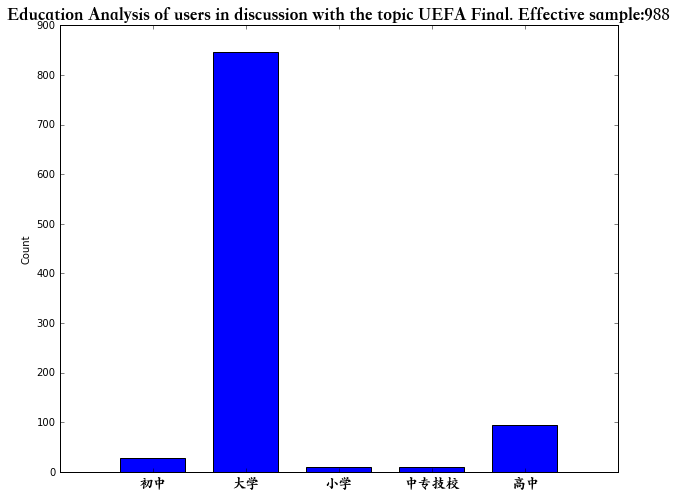

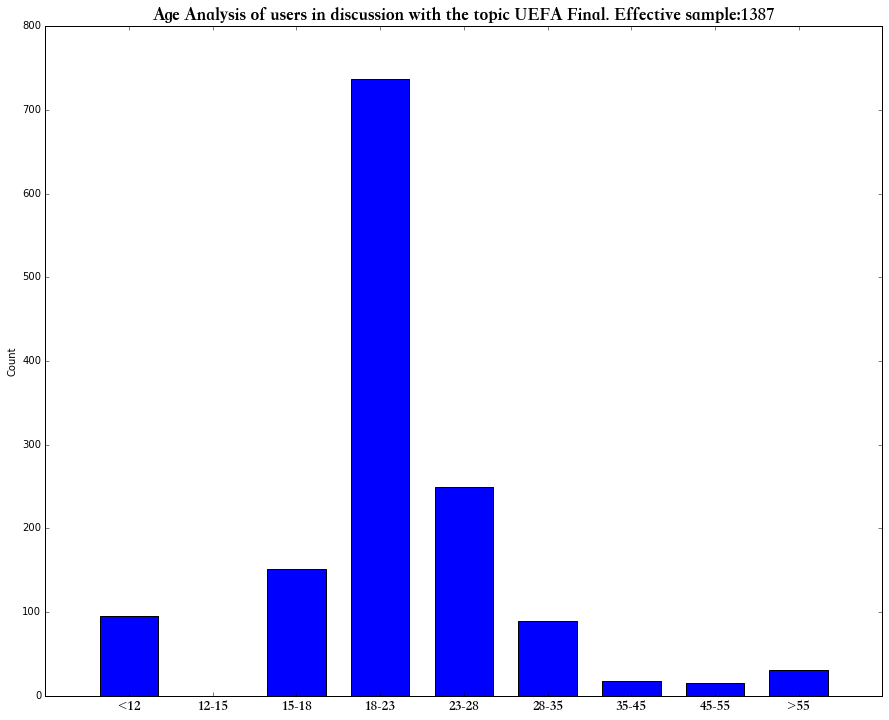

In [396]:
'''绘制柱状图'''
matplotlib.rcParams['figure.figsize'] = (20.0, 12.0)
chfont = FontProperties(fname='/Library/Fonts/Kaiti.ttc', size=18)
chfont1 = FontProperties(fname='/Library/Fonts/Kaiti.ttc', size=14)
index = np.arange(1, len(location_dict) + 1)
rect2 = plt.bar(left = index, height = location_dict.values(), width = 0.5, align = 'center')
plt.ylabel('Count')
plt.title('Location Analysis of users in discussion with the topic %s. Effective sample:%d' %\
          (theme, sum(location_dict.values())),fontproperties = chfont)
plt.xticks(index, location_dict.keys(), fontproperties = chfont1)
plt.show()

matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
index = np.arange(1, len(education_dict) + 1)
rect2 = plt.bar(left = index, height = education_dict.values(), width = 0.7, align = 'center')
plt.ylabel('Count')
plt.title('Education Analysis of users in discussion with the topic %s. Effective sample:%d' %\
          (theme, sum(education_dict.values())),fontproperties = chfont)
plt.xticks(index, education_dict.keys(), fontproperties = chfont1)
plt.show()

birth_dict_order = ['<12','12-15','15-18','18-23','23-28','28-35','35-45','45-55','>55']
sorted_birth_dict_vals = [birth_dict[k] for k in birth_dict_order]
x = sorted(birth_dict.items(), key = lambda birth_dict_order:birth_dict_order[1])
#print x
matplotlib.rcParams['figure.figsize'] = (15.0, 12.0)
index = np.arange(1, len(birth_dict) + 1)
rect2 = plt.bar(left = index, height = sorted_birth_dict_vals, width = 0.7, align = 'center')
plt.ylabel('Count')
plt.title('Age Analysis of users in discussion with the topic %s. Effective sample:%d' %\
          (theme, sum(sorted_birth_dict_vals)),fontproperties = chfont)
plt.xticks(index, birth_dict_order, fontproperties = chfont1)
plt.show()

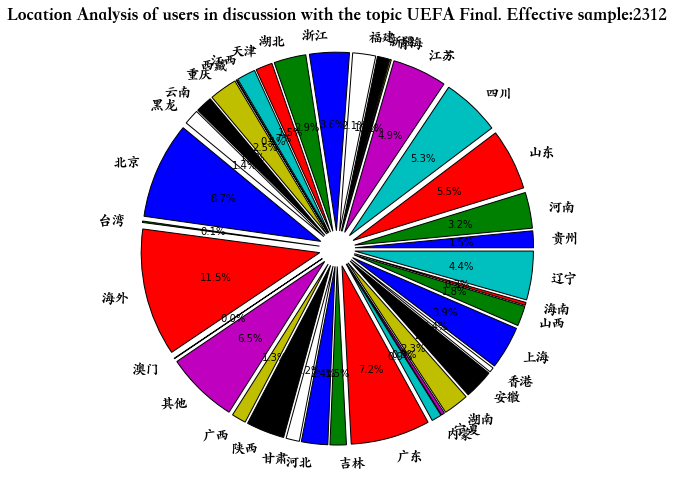

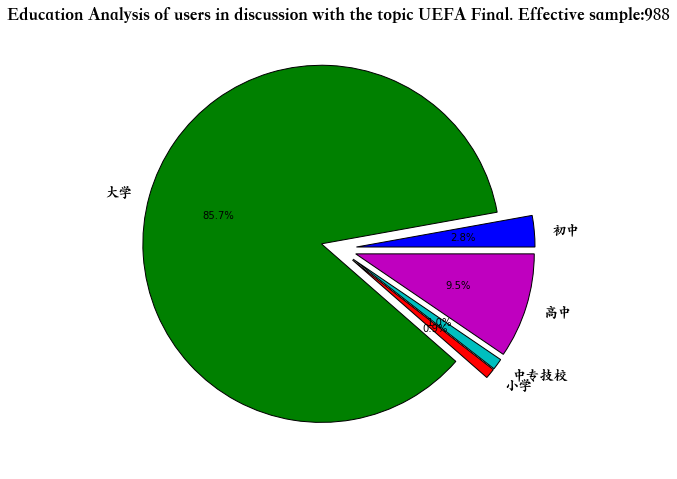

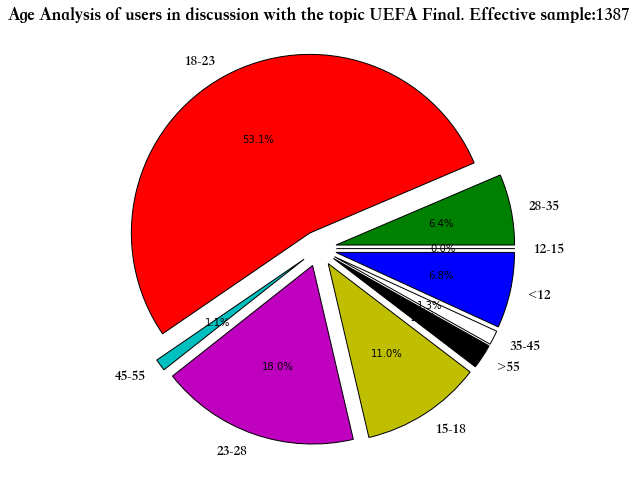

In [410]:
'''绘制饼图'''
chfont1 = FontProperties(fname='/Library/Fonts/Kaiti.ttc', size=14)
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
pie1 = plt.pie(location_dict.values(), 
               labels = location_dict.keys(), 
               explode = np.ones(len(location_dict.values()))*0.1,
               autopct = '%1.1f%%')
for font in pie1[1]:
    font.set_fontproperties(chfont1)
plt.title('Location Analysis of users in discussion with the topic %s. Effective sample:%d' %\
          (theme, sum(location_dict.values())),fontproperties = chfont)
plt.show()

pie2 = plt.pie(education_dict.values(), 
               labels = education_dict.keys(), 
               explode = np.ones(len(education_dict.values()))*0.1, 
               autopct = '%1.1f%%')
for font in pie2[1]:
    font.set_fontproperties(chfont1)
plt.title('Education Analysis of users in discussion with the topic %s. Effective sample:%d' %\
          (theme, sum(education_dict.values())),fontproperties = chfont)
plt.show()

pie3 = plt.pie(birth_dict.values(), 
               labels = birth_dict.keys(), 
               explode = np.ones(len(birth_dict.values()))*0.1, 
               autopct = '%1.1f%%')
for font in pie3[1]:
    font.set_fontproperties(chfont1)
plt.title('Age Analysis of users in discussion with the topic %s. Effective sample:%d' %\
          (theme, sum(birth_dict.values())),fontproperties = chfont)
plt.show()

In [14]:
'''抓取话题的关注用户信息（uid，昵称，所在地，性别）'''
iteration = 2
total = crawler.get_fans_by_theme(container_id='230403_-_10080819c366f62380fecd399270159fcc2184', 
                                  uid='5223526177', cookie_dict = cookie, page=iteration, retry = 3)
theme_fans_list = total[0]
theme_fans = total[1]
null_count = 0
for iteration in xrange(3, 650):
    time.sleep(1)
    page = crawler.get_fans_by_theme(container_id='230403_-_10080819c366f62380fecd399270159fcc2184', 
                                  uid='5223526177', cookie_dict = cookie, page=iteration, retry = 5)
    if page == 0: #若返回0，则代表出错，多次尝试
        null_count += 1
        if null_count >= 5: #最多尝试5次，则判定账号被封禁
            break
        else:
            continue
    elif null_count > 0:
        null_count = 0
    theme_fans.extend(page[1])
    if iteration % 50 == 0: #每隔50页进行输出并保存变量
        output = open('theme_fans.pk1','wb')
        pickle.dump(theme_fans, output, -1)
        print iteration
        print ', '.join(theme_fans[iteration])
output = open('theme_fans.pk1','wb')
pickle.dump(theme_fans, output, -1)

50
Future-World, 5666602979, 广东, m
100
Gr-LXY, 3954054187, 河南, m
150
秋本明超, 2537826620, 海外, m
200
泽夕君, 2796361250, 广东, f
250
用户5432516942, 5432516942, 其他, m
300
Lell丶, 3127504257, 江苏, m
350
K__YY___WWW____, 3170510997, 陕西, m
400
YONG酱海外母婴, 1904158674, 湖南, m
450
gyf52113142016, 5940066431, 吉林, m
500
欢NICO, 1778410581, 浙江, f


In [20]:
file = open('theme_fans.pk1','rb')
theme_fans = pickle.load(file)
file.close()

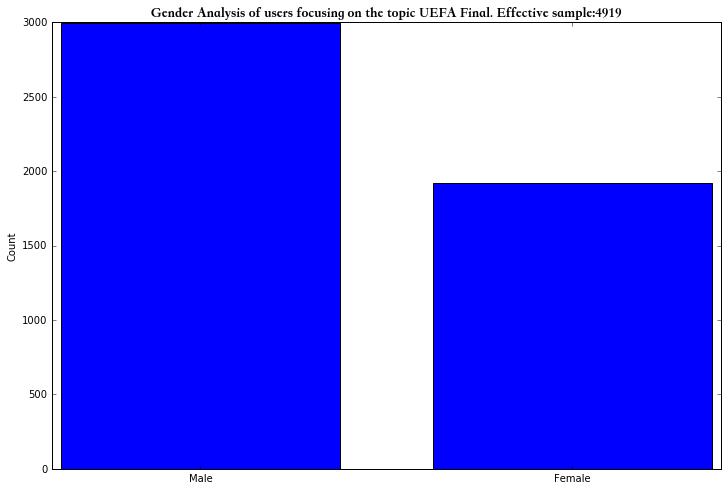

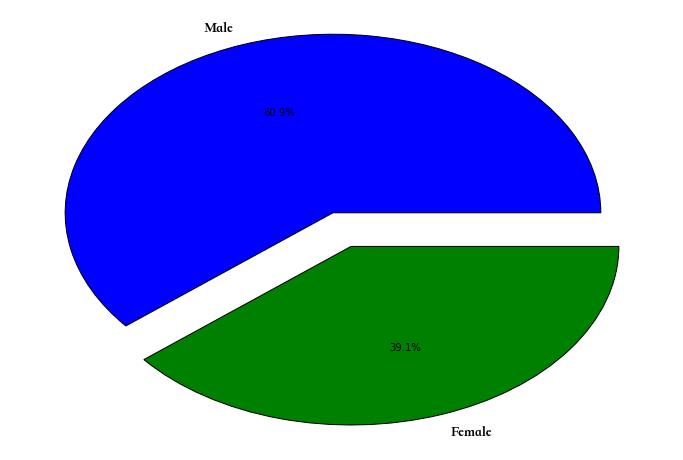

In [399]:
'''关注用户的性别分析'''
m = 0
f = 0
for i in theme_fans:
    if i [3] == 'm':
        m += 1
    elif i[3] == 'f':
        f += 1
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
chfont = FontProperties(fname='/Library/Fonts/Kaiti.ttc', size=14)
index = np.arange(1, 3)
rect = plt.bar(left=index, height=(m,f), width = 0.75, align = 'center')
plt.title('Gender Analysis of users focusing on the topic %s. Effective sample:%d' % (theme, len(theme_fans)),
         fontproperties = chfont)
plt.ylabel('Count')
plt.xticks(index, ('Male','Female'))
plt.show()

pie = plt.pie((m, f), 
               labels = ('Male', 'Female'), 
               explode = np.ones(2)*0.1, 
               autopct = '%1.1f%%')
for font in pie[1]:
    font.set_fontproperties(chfont)
plt.show()

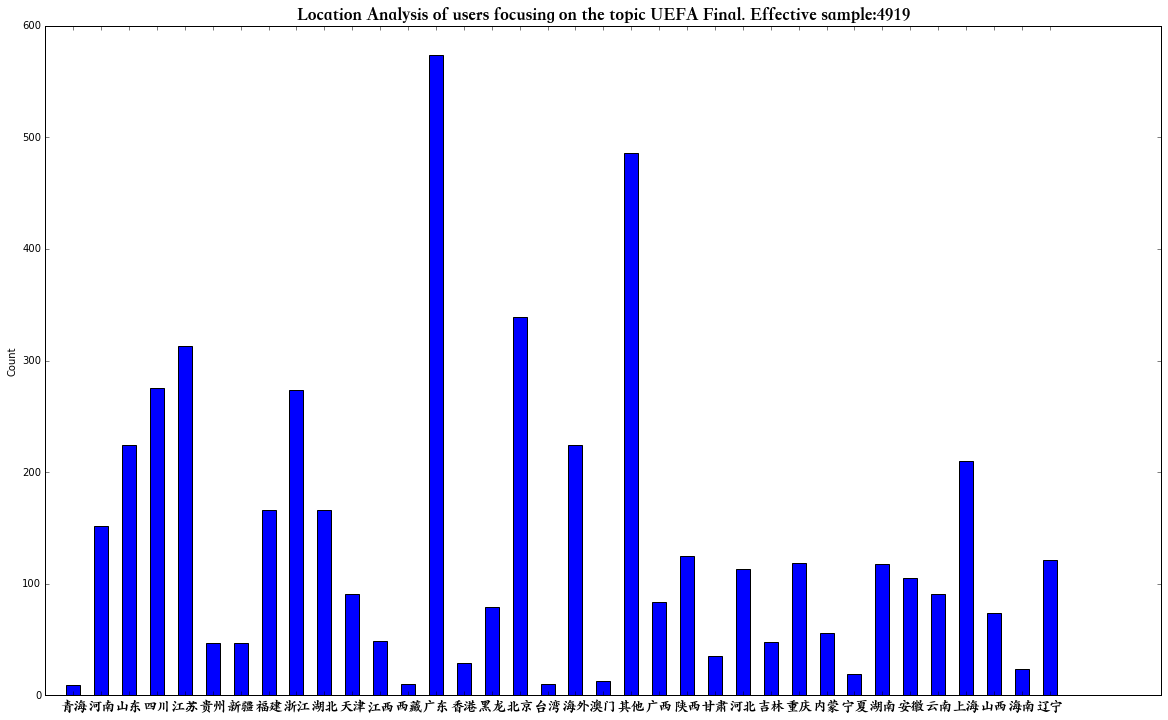

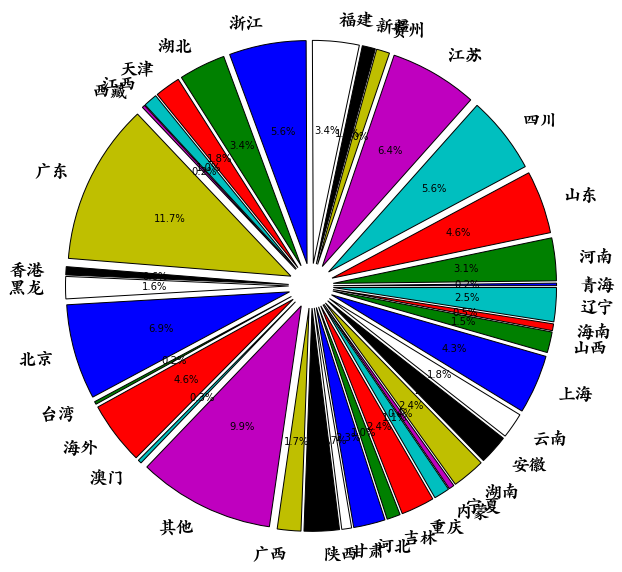

In [400]:
'''关注用户的地理位置分析'''
location = {}
for i in theme_fans:
    if i[2] in location:
        location[i[2]] += 1
    else:
        location[i[2]] = 1

matplotlib.rcParams['figure.figsize'] = (20.0, 12.0)
chfont = FontProperties(fname='/Library/Fonts/Kaiti.ttc', size=18)
chfont1 = FontProperties(fname='/Library/Fonts/Kaiti.ttc', size=14)
index = np.arange(1, len(location) + 1)
rect2 = plt.bar(left = index, height = location.values(), width = 0.5, align = 'center')
plt.ylabel('Count')
plt.title('Location Analysis of users focusing on the topic %s. Effective sample:%d' % (theme, len(theme_fans)),
         fontproperties = chfont)
plt.xticks(index, location.keys(), fontproperties = chfont1)
plt.show()

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
pie = plt.pie(location.values(), 
               labels = location.keys(), 
               explode = np.ones(len(location.values()))*0.1, 
               autopct = '%1.1f%%')
for font in pie[1]:
    font.set_fontproperties(chfont)
plt.show()

In [101]:
'''抓取关注用户的地理位置、教育信息和年龄信息'''
i = 0
flag = 0
theme_fans_info = []
print 'Geting basic info...'
while i < len(theme_fans):
    time.sleep(3)
    info = get_basic_info(theme_fans[i][1], cookie, 3)
    if flag == 3: 
        i += 1
        flag = 0
        continue
    if info == 0:
        time.sleep(10)
        flag += 1
        continue
    theme_fans_info.append(info)
            
    if (i+1)%500 == 0:
        print i
        print ', '.join(info)
        output = open('theme_fans_info.pk1','wb')
        pickle.dump(theme_fans_info, output, -1)

    i += 1
    
output = open('theme_fans_info.pk1','wb')
pickle.dump(theme_fans_info, output, -1)

Geting basic info...
499
山东, -1, -1
999
上海, 高中, 18
1499
黑龙, -1, -1
1999
北京, -1, -1
2499
香港, 初中, 17
2999
四川, -1, 28
3499
广西, -1, 46
3999
广东, -1, -1
4499
湖北, -1, 26


In [401]:
file = open('theme_fans_info.pk1','rb')
theme_fans_info = pickle.load(file)
file.close()

In [402]:
'''对信息进行统计，只统计教育和年龄信息'''
_, education_dict_2, birth_dict_2 = dict_stat(theme_fans_info)

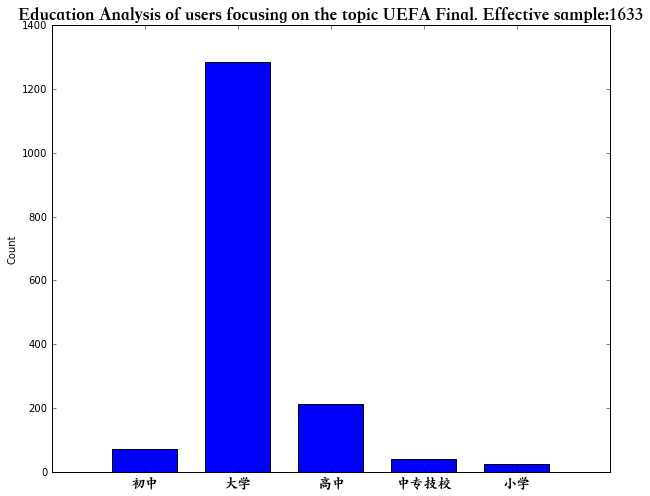

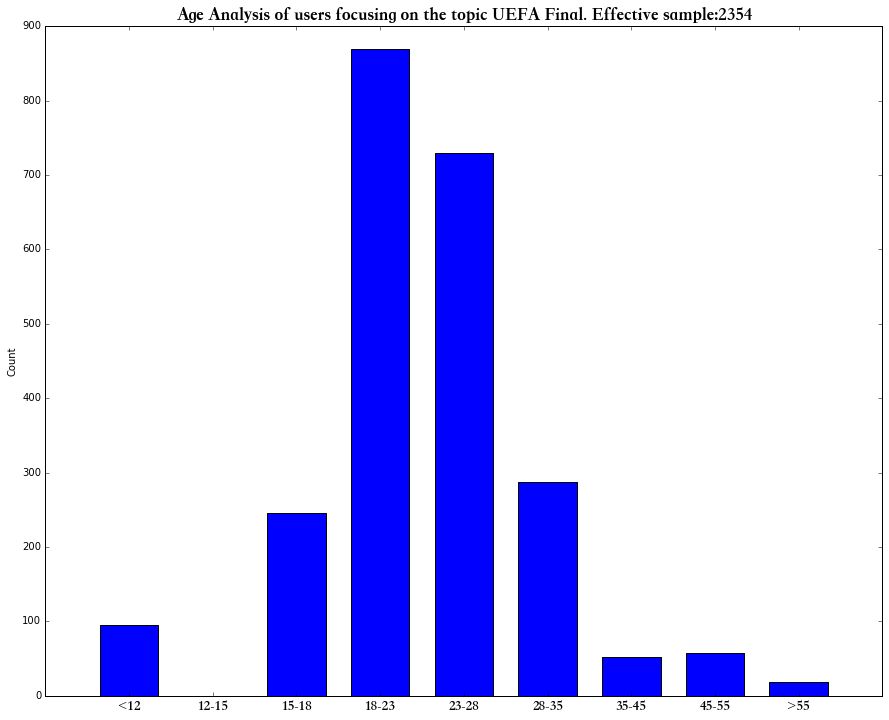

In [403]:
'''绘制柱状图'''
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
index = np.arange(1, len(education_dict_2) + 1)
rect2 = plt.bar(left = index, height = education_dict_2.values(), width = 0.7, align = 'center')
plt.ylabel('Count')
plt.title('Education Analysis of users focusing on the topic %s. Effective sample:%d' %\
          (theme, sum(education_dict_2.values())),fontproperties = chfont)
plt.xticks(index, education_dict_2.keys(), fontproperties = chfont1)
plt.show()

birth_dict_order = ['<12','12-15','15-18','18-23','23-28','28-35','35-45','45-55','>55']
sorted_birth_dict_2_vals = [birth_dict_2[k] for k in birth_dict_order]
x = sorted(birth_dict_2.items(), key = lambda birth_dict_order:birth_dict_order[1])
#print x
matplotlib.rcParams['figure.figsize'] = (15.0, 12.0)
index = np.arange(1, len(birth_dict) + 1)
rect2 = plt.bar(left = index, height = sorted_birth_dict_2_vals, width = 0.7, align = 'center')
plt.ylabel('Count')
plt.title('Age Analysis of users focusing on the topic %s. Effective sample:%d' %\
          (theme, sum(sorted_birth_dict_2_vals)),fontproperties = chfont)
plt.xticks(index, birth_dict_order, fontproperties = chfont1)
plt.show()

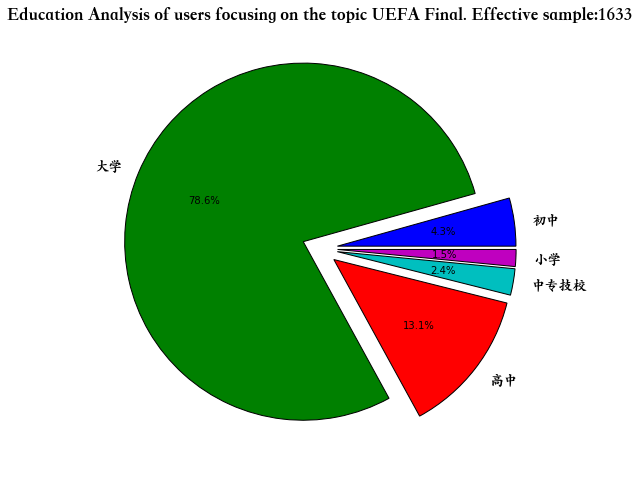

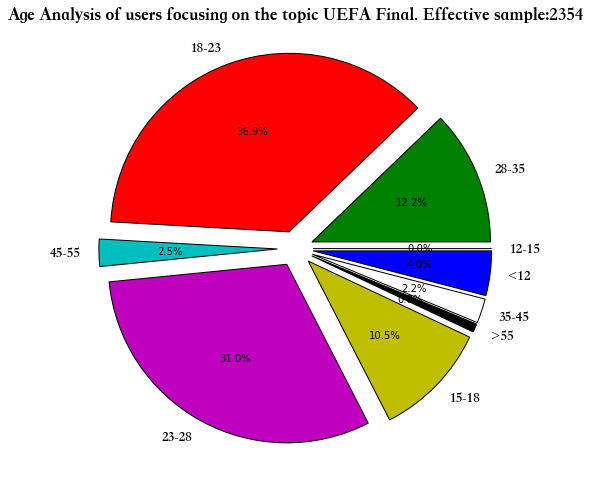

In [411]:
'''绘制饼图'''
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
pie1 = plt.pie(education_dict_2.values(), 
               labels = education_dict_2.keys(), 
               explode = np.ones(len(education_dict_2.values()))*0.1, 
               autopct = '%1.1f%%')
for font in pie1[1]:
    font.set_fontproperties(chfont1)
plt.title('Education Analysis of users focusing on the topic %s. Effective sample:%d' %\
          (theme, sum(education_dict_2.values())),fontproperties = chfont)
plt.show()

pie2 = plt.pie(birth_dict_2.values(), 
               labels = birth_dict_2.keys(), 
               explode = np.ones(len(birth_dict_2.values()))*0.1, 
               autopct = '%1.1f%%')
for font in pie2[1]:
    font.set_fontproperties(chfont1)
plt.title('Age Analysis of users focusing on the topic %s. Effective sample:%d' %\
          (theme, sum(birth_dict_2.values())),fontproperties = chfont)
plt.show()

In [30]:
'''users_list和fans_list为仅记录讨论用户和关注用户的uid的列表'''
users_list = []
fans_list = []
        #print i[0]
for i in theme_fans:
    if i[1] not in fans_list:
        fans_list.append(i[1])
for i in theme_users:
    if i[1] not in users_list:
        users_list.append(i[1])

4331 4909
4982


In [31]:
output = open('fans_list.pk1','wb')
pickle.dump(fans_list, output, -1)
output = open('users_list.pk1','wb')
pickle.dump(users_list, output, -1)

In [260]:
file = open('fans_list.pk1','rb')
fans_list = pickle.load(file)
file = open('users_list.pk1','rb')
users_list = pickle.load(file)
print len(fans_list)
print len(users_list)

4909
4331


In [6]:
'''
一些函数的实现
'''

'''统计图中每个结点的的出入度'''
def in_and_out(mydict):
    count = {}
    for i in mydict.keys():
        if i not in count:
            count[i] = [0,0]
        count[i][0] += len(mydict[i][1])
        if len(mydict[i][1]) > 0:
            for j in mydict[i][1]:
                if j not in count:
                    count[j] = [0, 1]
                else:
                    count[j][1] += 1
    return count

'''统计所抓用户关注列表中，不在所抓用户里但是在大的用户群里（即讨论用户和关注用户群）的用户，认为其可能是大V'''
def maybe_V(mydict):
    V = {}
    start = len(mydict)
    for i in mydict.keys():
        if len(mydict[i][1]) > 0:
            for j in mydict[i][1]:
                if j not in mydict.keys():
                    if j not in V:
                        V[j] = [start, [i]]
                        start += 1
                    else:
                        V[j][1].append(i)
    return V

'''深度优先搜索，返回孤岛'''
def DFS(mydict):
    visited_dict = dict(mydict.items())
    island = []
    for vertex in visited_dict.keys():
        visited_dict[vertex].append(0)
    for vertex in visited_dict.keys():
        if visited_dict[vertex][2] == 0:
            x = 1
            island.append(DFS_visit(visited_dict, vertex, x))
    return island

'''对每个节点进行深度优先搜索访问的函数，被DFS所调用'''
def DFS_visit(mydict1, vertex, node_count):
    mydict1[vertex][2] = 1
    if len(mydict1[vertex][1]) > 0:
        for neighbour in mydict1[vertex][1]:
            if mydict1[neighbour][2] == 0:
                node_count += 1
                node_count = DFS_visit(mydict1, neighbour, node_count)
    mydict1[vertex][2] = 2
    return node_count

'''将本实验自定的图的数据格式存为CSV格式'''
def Graph2CSV(filename1, filename2, VandNotV_dict, mylist, lenV):
    assert filename1.split('.')[1] == 'csv' and filename2.split('.')[1] == 'csv'
    reload(sys)
    sys.setdefaultencoding('utf-8')
    '''Edges'''
    f = open(filename1, 'w')
    f.write('Source,Target\n')
    for key in VandNotV_dict.keys():
        if VandNotV_dict[key][0] < lenV and len(VandNotV_dict[key][1]) > 0:
            for i in VandNotV_dict[key][1]:
                f.write(str(VandNotV_dict[key][0])+','+str(VandNotV_dict[i][0])+'\n')
    f.close()
    
    '''Vertexs'''
    f1 = open(filename2, 'w')
    f1.write('Id,Label,Modularity Class\n')
    for key in VandNotV_dict.keys():
        for x in mylist:
            if x[1] == key:
                f1.write(str(VandNotV_dict[key][0])+','+x[0]+','+'0'+'\n')
                break
    f1.close()

In [267]:
fans_not_V = {}

In [277]:
'''抓取话题关注用户的关注列表，抓了约800个用户后人为停止'''

cookie1 ={'_T_WM':'a1f17feb717856dc5aab594c4aa54edb', 
              'gsid_CTandWM':'4uCFCpOz5kOmrO6XPJnpT7r229X', 
              'H5_INDEX':'3', 'H5_INDEX_TITLE':'Justin%E5%90%9B%E5%AD%90%E9%9B%B7', 
              #'M_WEIBOCN_PARAMS':'featurecode%3D20000181%26luicode%3D10000011%26lfid%3D1005055223526177%26fid%\
              #3D1005055223526177_-_FANS%26uicode%3D10000012',
              'SSOLoginState':'1464933178', 
              'SUB':'_2A256VWtpDeTxGedJ7FAT8S7KyjuIHXVZtnUhrDV6PUJbkdBeLRD1kW2AEZALKPj7YxUpVOwRLV8Ez0a2vg..', 
              'SUHB':'0oU5zEgt0R-XLX'}
cut1 = 150 #仅抓关注列表数小于cut1的用户
g1 = 0
for i in xrange(0, len(fans_list)):
    time.sleep(5)
    cookie1['M_WEIBOCN_PARAMS'] = \
    'featurecode%3D20000181%26luicode%3D10000011%26lfid%3D100505'+fans_list[i]+'%26fid%3D100505'+fans_list[i]+'\
    _-_FOLLOWERS%26uicode%3D10000012'
    num_fans, y = crawler.get_focus_or_fans_by_id(fans_list[i], cookie1, 'focus')
    if num_fans == None and y == None:
        continue
    if num_fans > cut1: 
        continue
    fans_not_V[fans_list[i]] = [g1, []]
    g1 += 1
    page1 = 1
    while True:
        time.sleep(5)
        _, fans = crawler.get_focus_or_fans_by_id(fans_list[i], cookie1, 'focus', page1, 2)
        if fans == None:
            break
        for j in fans:
            if j in fans_list:
                fans_not_V[fans_list[i]][1].append(j)
        page1 += 1
        if page1 > 9:
            break ###
    
    if g1 % 20 == 0:
        output = open('fans_not_V.pk1','wb')
        pickle.dump(fans_not_V, output, -1)
        print g1, fans_not_V[fans_list[i]]
    

320 [319, []]
340 [339, []]
360 [359, []]
380 [379, []]
400 [399, []]
420 [419, []]
440 [439, ['2993049293']]
460 [459, []]
480 [479, ['3083675110']]
500 [499, ['2993049293', '3083675110']]
520 [519, []]
540 [539, []]
560 [559, []]
580 [579, []]
600 [599, []]
620 [619, []]
640 [639, []]
660 [659, []]
680 [679, []]
700 [699, []]
720 [719, ['3083675110']]
740 [739, []]
760 [759, []]
780 [779, []]
800 [799, []]
820 [819, ['3083675110']]
840 [839, ['3083675110']]


KeyboardInterrupt: 

In [310]:
output = open('fans_not_V.pk1','wb')
pickle.dump(fans_not_V, output, -1)
output.close()

In [17]:
file = open('fans_not_V.pk1','rb')
fans_not_V = pickle.load(file)
file.close()

In [316]:
print len(fans_not_V)
print len(fans_list)
print i
print g1

857
4909
5259320079
857


In [18]:
'''找出可能是大V的用户'''
fans_V = maybe_V(fans_not_V) #fans_V的数据格式与fans_not_V的格式一样，只不过fans_V的列表中是粉丝列表
print len(fans_V)

13


In [318]:
output = open('fans_V.pk1','wb')
pickle.dump(fans_V, output, -1)

In [21]:
'''一些处理'''
new_fans_dict = dict(fans_not_V.items() + fans_V.items()) #将非大V和大V的用户拼接在一起，
Graph2CSV('fans_edge.csv', 'fans_vertex.csv', new_fans_dict, theme_fans, len(fans_not_V)) #将数据存成CSV格式
fans_ISLAND = DFS(new_fans_dict) #找出每个孤岛

In [320]:
'''打印孤岛列表，每个元素代表一个孤岛，其数目表示孤岛中的用户数'''
print fans_ISLAND
print np.sum(fans_ISLAND)

[191, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [22]:
'''统计每个用户的出入度'''
fans_degree = in_and_out(fans_not_V)

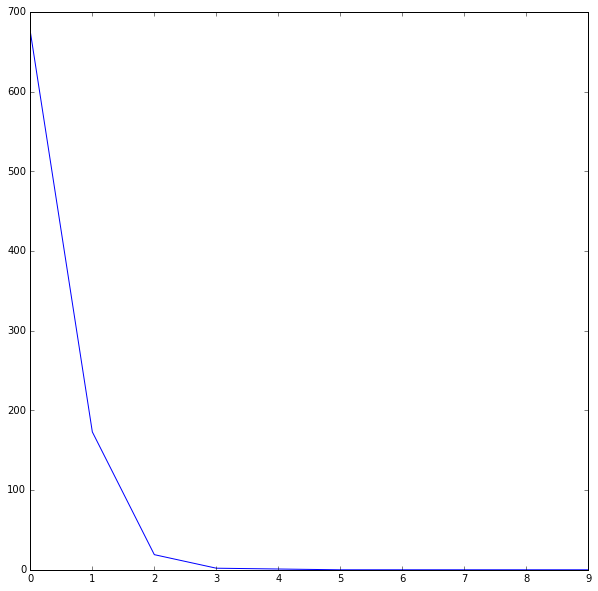

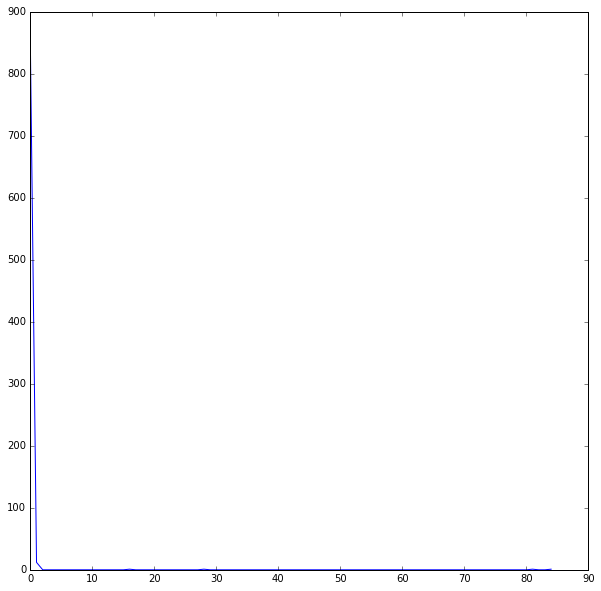

In [30]:
'''画出话题关注用户组成的社交网络的结点出／入度分布'''
out_distribute = np.zeros(10)
in_distribute = np.zeros(85)
matplotlib.rcParams['figure.figsize'] = (10, 10.0)
#print out_distribute
for p in fans_degree.keys():
    out_distribute[fans_degree[p][0]] += 1 #fans_degree[p][0]代表出度，fans_degree[p][1]代表入度
    in_distribute[fans_degree[p][1]] += 1
plt.plot(out_distribute)
plt.show()
plt.plot(in_distribute)
plt.show()

In [235]:
'''抓取话题讨论用户的关注列表，抓取约600人后人为停止'''

cookie2 ={'_T_WM':'a1f17feb717856dc5aab594c4aa54edb', 
              'gsid_CTandWM':'4uCFCpOz5kOmrO6XPJnpT7r229X', 
              'H5_INDEX':'3', 'H5_INDEX_TITLE':'Justin%E5%90%9B%E5%AD%90%E9%9B%B7', 
              #'M_WEIBOCN_PARAMS':'featurecode%3D20000181%26luicode%3D10000011%26lfid%3D1005055223526177%26fid%\
              #3D1005055223526177_-_FANS%26uicode%3D10000012',
              'SSOLoginState':'1464933178', 
              'SUB':'_2A256VWtpDeTxGedJ7FAT8S7KyjuIHXVZtnUhrDV6PUJbkdBeLRD1kW2AEZALKPj7YxUpVOwRLV8Ez0a2vg..', 
              'SUHB':'0oU5zEgt0R-XLX'}
cut = 150 
users_not_V = {}
g = 0
for i in xrange(0, len(users_list)):
    time.sleep(5)
    cookie2['M_WEIBOCN_PARAMS'] = \
    'featurecode%3D20000181%26luicode%3D10000011%26lfid%3D100505'+users_list[i]+'%26fid%3D100505'+users_list[i]+'\
    _-_FOLLOWERS%26uicode%3D10000012'
    num_focus, x = crawler.get_focus_or_fans_by_id(users_list[i], cookie2, 'focus')
    if num_focus == None and x == None:
        continue
    if num_focus > cut:
        continue
    users_not_V[users_list[i]] = [g, []]
    g += 1
    page1 = 1
    while True:
        time.sleep(5)
        _, focus = crawler.get_focus_or_fans_by_id(users_list[i], cookie2, 'focus', page1, 2)
        if focus == None:
            break
        for j in focus:
            if j in users_list:
                users_not_V[users_list[i]][1].append(j)
        page1 += 1
        if page > 9:
            break ###

    
    if g % 20 == 0:
        output = open('users_not_V.pk1','wb')
        pickle.dump(users_not_V, output, -1)
        print g, users_not_V[users_list[i]]
    

360 [359, []]
380 [379, []]
400 [399, []]
420 [419, []]
440 [439, ['2018499075']]
460 [459, []]
480 [479, []]
500 [499, ['1990309453']]
520 [519, ['2993049293']]
540 [539, []]


KeyboardInterrupt: 

In [342]:
print len(users_not_V)
print len(users_list)
print i
print g

557
4331
5505062251
558


In [340]:
output = open('users_not_V.pk1','wb')
pickle.dump(users_not_V, output, -1)
output.close()

In [28]:
file = open('users_not_V.pk1','rb')
users_not_V = pickle.load(file)
file.close()

In [337]:
'''找出可能的大V'''
V = maybe_V(users_not_V)
print len(V)

61


In [338]:
output = open('V.pk1','wb')
pickle.dump(V, output, -1)

In [370]:
new_dict = dict(users_not_V.items() + V.items())
Graph2CSV('users_edge.csv', 'users_vertex.csv', new_dict, theme_users, len(users_not_V))

In [293]:
ISLAND = DFS(new_dict)

In [294]:
print ISLAND
print np.sum(ISLAND)

[1, 272, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
618


In [7]:
degree = in_and_out(users_not_V)

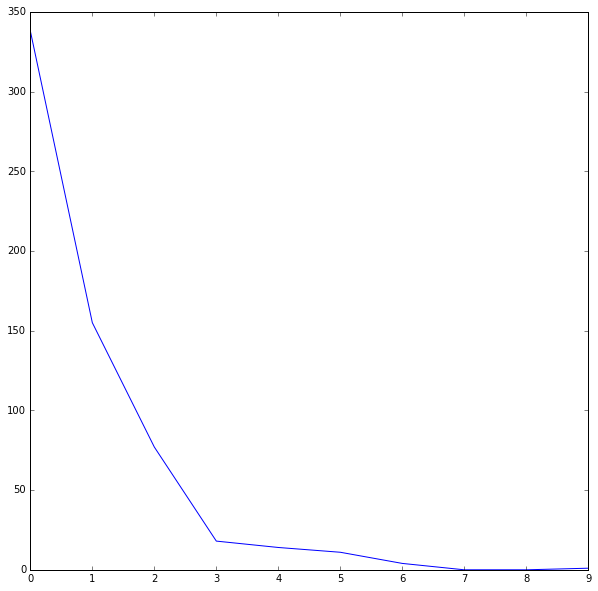

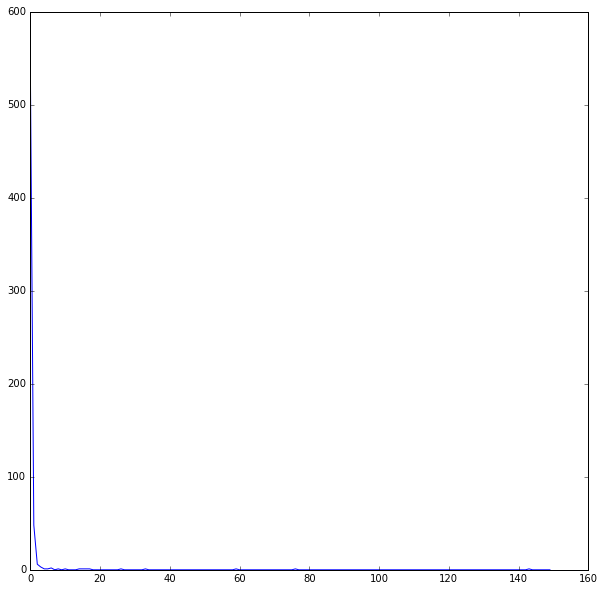

In [35]:
'''画出讨论用户组成的社交网络的结点出／入度分布'''
out_distribute = np.zeros(10)
in_distribute = np.zeros(150)
matplotlib.rcParams['figure.figsize'] = (10, 10)
#print out_distribute
for p in degree.keys():
    out_distribute[degree[p][0]] += 1 
    in_distribute[degree[p][1]] += 1#degree[p][0]代表出度，degree[p][1]代表入度
plt.plot(out_distribute)
plt.show()
plt.plot(in_distribute)
plt.show()